## Генерация полифонической музыки с кондишнингом

В этой версии используется VAE. Энкодер -- двухслойная полносвязная нейронная сеть, декодер -- зеркальная двухслойная полносвязная нейронная сеть.

Импортируем torch и numpy:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random

Сделаем также пользовательский импорт

In [2]:
from decode_patterns import data_conversion

In [3]:
data_height = 64
drum_width = 14
melody_width = 36
data_width = drum_width + melody_width
data_size = data_height*data_width
train_file = "decode_patterns/train.tsv" # обучающая выборка
validation_file = "decode_patterns/validation.tsv" # валидационная выборка
human_file = "decode_patterns/human.tsv" # как валидационная, только для ассесмента людей (read as "validation")

Загружаем датасет

In [4]:
# import dataset
drum, bass = data_conversion.make_lstm_dataset_conditioning(height=data_height,
                                                            patterns_file=train_file,
                                                            mono=False)

# define shuffling of dataset
def shuffle(A, B, p=0.8):
    # take 80% to training, other to testing
    AB = list(zip(A, B))
    L = len(AB)
    pivot = int(p*L)
    random.shuffle(AB)
    yield [p[0] for p in AB[:pivot]]
    yield [p[1] for p in AB[:pivot]]
    yield [p[0] for p in AB[pivot:]]
    yield [p[1] for p in AB[pivot:]]
    
    
# we can shuffle train and test set like this:
# drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)

# selecting a validation set
drum_validation, bass_validation = data_conversion.make_lstm_dataset_conditioning(height=data_height,
                                                                                  patterns_file=validation_file,
                                                                                  mono=False)

In [5]:
bass[16]

NumpyImage(image=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), tempo=96, instrument=27, denominator=4, min_note=45)

Модель определим в самом простом варианте, который только можно себе представить -- как в примере с конечным автоматом

In [6]:
# Encoder = LSTM
# Decoder = FCNN
class DrumNBass_FFNN_to_FFNN(nn.Module):
    
    def __init__(self, data_height, drum_width, melody_width):
        super(DrumNBass_FFNN_to_FFNN, self).__init__()
        
        self.data_height = data_height
        self.drum_width = drum_width
        self.melody_width = melody_width
        self.condition_size = 2 # размер подмешиваемого conditioning
        
        input_dim = data_height*drum_width
        latent_dim = 4
        hidden_dim = (input_dim + latent_dim) // 2
        output_dim = data_height*melody_width
        
        # Linear function 1: 128 * 14 = 1792 --> 2048
        # веса накидываются тут
        self.fc1 = nn.Linear(input_dim + self.condition_size, hidden_dim)
#         nn.init.normal_(self.fc1.weight, mean=1.5, std=1.0)
        # решение по весам
        self.relu1 = nn.Sigmoid()
        
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         nn.init.normal_(self.fc2.weight, mean=1.5, std=1.0)
        self.relu2 = nn.Sigmoid()


        # Linear function 31: 2048 --> 4
        # для средних значений
        self.fc31 = nn.Linear(hidden_dim, latent_dim)
        # Non-linearity 31
        self.relu31 = nn.Sigmoid()
        
        
        # Linear function 22: 2048 --> 4
        # для стандартных отклонений
        self.fc32 = nn.Linear(hidden_dim, latent_dim)
        # Non-linearity 22
        self.relu32 = nn.Sigmoid()

        # Linear function 4: 4 --> 2048
        self.fc4 = nn.Linear(latent_dim + self.condition_size, hidden_dim)
#         nn.init.normal_(self.fc4.weight, mean=1.5, std=1.0)
        # Non-linearity 4
        self.relu4 = nn.Sigmoid()
        
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
#         nn.init.normal_(self.fc5.weight, mean=1.5, std=1.0)
        self.relu5 = nn.Sigmoid()

        # Linear function 6 (readout): 2048 --> 128 * 36 = 4608
        self.fc6 = nn.Linear(hidden_dim, output_dim)  
        self.sigmoid = nn.Sigmoid()
        
    def encoder(self, x, cond):
        out = torch.cat((x, cond), axis=1) # добавляем conditioning
        # Linear function 1
        out = self.fc1(out)
        # Non-linearity 1
        out = self.relu1(out)
        
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 31
        mu = self.fc31(out)
        # Non-linearity 31
        mu = self.relu31(mu)
        
        
        # Linear function 22
        logvar = self.fc32(out)
        # Non-linearity 22
        logvar = self.relu32(logvar)
        
        return mu, logvar
    
    # reference:
    # https://github.com/pytorch/examples/blob/master/vae/main.py
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    # end reference
    
    def decoder(self, x, cond):
        out = torch.cat((x, cond), axis=1) # добавляем conditioning
        # Linear function 4
        out = self.fc4(out)
        # Non-linearity 4
        out = self.relu4(out)
        
        # Linear function 5
        out = self.fc5(out)
        # Non-linearity 5
        out = self.relu5(out)

        # Linear function 6 (readout)
        out = self.fc6(out)
        out = self.sigmoid(out)
        return out
    
    @staticmethod
    def get_images(input):
        return torch.tensor(list(map(lambda p: p.image.flatten(), input)), dtype=torch.float)
    
    @staticmethod
    def get_conditionings(input):
        return torch.tensor(list(map(lambda p: [p.tempo, p.instrument], input)), dtype=torch.float)
    
    def forward(self, x):
        # добавляем conditioning
        conditionings = self.get_conditionings(x)
        images = self.get_images(x)
        mean, logvar = self.encoder(images, conditionings)
        # генерируем случайную точку в латентном пространстве
        result = self.reparameterize(mean, logvar)
        result = self.decoder(result, conditionings)
        return result.view((-1, self.data_height, self.melody_width)), mean, logvar

In [7]:
# часть обучения
dnb_ffnn = DrumNBass_FFNN_to_FFNN(data_height, drum_width, melody_width)

# criterion = nn.MSELoss() # -- с этим всё работает (точнее, работало)
# criterion = nn.NLLLoss() # -- этот товарищ требует, чтобы LSTM выдавал классы,
# criterion = nn.CrossEntropyLoss() # и этот тоже
# (числа от 0 до C-1), но как всё-таки его заставить это делать?...

# оценим также и разнообразие мелодии по её.. дисперсии?)
# def melody_variety(melody):
#     return 1/(1 + (melody.sum(axis=2) > 1).int())

# на самом деле, попробуем функцию потерь взять из VAE

# Reference: https://github.com/pytorch/examples/blob/master/vae/main.py
# Reconstruction + KL divergence losses summed over all elements and batch
def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

def reconstruction_KL_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

optimizer = optim.Adam(dnb_ffnn.parameters(), lr=0.001)
# optimizer = optim.SGD(dnb_ffnn.parameters(), lr=0.001, momentum=0.9)

Посмотрим, как модель форвардится на один пример

In [8]:
dnb_ffnn.forward([drum_validation[16], drum_validation[14], drum_validation[43]])[0].size()

torch.Size([3, 64, 36])

In [9]:
bass_validation[16].image.shape

(64, 36)

Найденные баги и их решения:

https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ

https://stackoverflow.com/questions/49206550/pytorch-error-multi-target-not-supported-in-crossentropyloss/49209628

https://stackoverflow.com/questions/56243672/expected-target-size-50-88-got-torch-size50-288-88

In [11]:
epoch_count = 72
batch_size = 64
shuffle_every_epoch = True
    
if shuffle_every_epoch:
    print(f"shuffle_every_epoch is on")
else:
    print(f"shuffle_every_epoch is off")
    # shuffle train and test set:
    drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)
    
def calc_loss_on(drum, bass, description):
    with torch.no_grad():
        batch_bass_raw = torch.tensor(list(map(lambda p: p.image, bass)), dtype=torch.float)
        bass_outputs, _, _ = dnb_ffnn(drum)

        count = len(drum)
        loss = 0
        for k in range(count):
            loss += reconstruction_loss(bass_outputs[k], batch_bass_raw[k])
        print(f"#{epoch + 1} {description}: {loss/count}")
        
for epoch in range(epoch_count):  # loop over the dataset multiple times
    print(f"Epoch #{epoch}")
    if shuffle_every_epoch:
        # shuffle train and test set:
        drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)
        
    examples_count = len(drum_train)
    examples_id = 0
    
    running_loss = 0.0
    runnint_count = 0
    batch_id = 0
    while examples_id < examples_count:
        batch_drum_train = drum_train[examples_id:examples_id + batch_size]
        batch_bass_train = bass_train[examples_id:examples_id + batch_size]
        current_batch_size = len(batch_drum_train)
        
        batch_bass_train_raw = torch.tensor(list(map(lambda p: p.image, batch_bass_train)), dtype=torch.float)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        bass_outputs, mu, stddev = dnb_ffnn(batch_drum_train)
        # bass_outputs = bass_outputs.squeeze()
        
        # loss = criterion(bass_outputs, batch_bass_train_raw)
        loss = 0
        for i in range(current_batch_size):
            loss += reconstruction_KL_loss_function(bass_outputs[i], batch_bass_train_raw[i], mu[i], stddev[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        runnint_count += 1
        period = 5
        if batch_id % period == 0 or examples_id + batch_size >= examples_count:
            print('[%d, %5d] train loss: %.7f' %
                  (epoch + 1, batch_id + 1, running_loss / runnint_count))
            running_loss = 0.0
            runnint_count = 1
            
        # update batch info
        examples_id += batch_size
        batch_id += 1
        
    # here we can insert measure error on test set
    calc_loss_on(drum_test, bass_test, "reconstruction test loss")
    calc_loss_on(drum_validation, bass_validation, "reconstruction validation loss")
    torch.save(dnb_ffnn.state_dict(), f"models/vae_fcnn_fcnn_{epoch+1}iter")
    

#should check accuracy on validation set

shuffle_every_epoch is on
Epoch #0
[1,     1] train loss: 6928.3706055
[1,     6] train loss: 5921.8031413
[1,    11] train loss: 5963.7903646
[1,    16] train loss: 5805.0757650
[1,    21] train loss: 5834.2417806
[1,    26] train loss: 5983.8310547
[1,    31] train loss: 5811.6764323
[1,    36] train loss: 5945.5245768
[1,    41] train loss: 5650.2495117
[1,    46] train loss: 5897.0062663
[1,    51] train loss: 6009.6580404
[1,    56] train loss: 5743.2788900
[1,    61] train loss: 6011.6407878
[1,    66] train loss: 5861.7403158
[1,    71] train loss: 5861.8391113
[1,    76] train loss: 5811.7207031
[1,    81] train loss: 5638.9197591
[1,    86] train loss: 6023.7460938
[1,    91] train loss: 5726.4121094
[1,    96] train loss: 6017.1227214
[1,   101] train loss: 5900.8854167
[1,   106] train loss: 5842.2268880
[1,   111] train loss: 5946.9465332
[1,   116] train loss: 6219.3322754
[1,   121] train loss: 6061.3289388
[1,   126] train loss: 5870.4851074
[1,   131] train loss: 5741.6

[2,   486] train loss: 5611.2970378
[2,   491] train loss: 5833.7227376
[2,   496] train loss: 5778.2229004
[2,   501] train loss: 5898.8133952
[2,   506] train loss: 5929.2091471
[2,   511] train loss: 5865.7534180
[2,   516] train loss: 5868.3014323
[2,   521] train loss: 5819.3842773
[2,   526] train loss: 6298.0575358
[2,   531] train loss: 5941.1722819
[2,   536] train loss: 5690.3405762
[2,   541] train loss: 5786.4567057
[2,   546] train loss: 5951.0177409
[2,   551] train loss: 6025.2040202
[2,   556] train loss: 5724.3911133
[2,   561] train loss: 5844.8251139
[2,   566] train loss: 5656.4993490
[2,   571] train loss: 5930.7271322
[2,   576] train loss: 5874.1820475
[2,   581] train loss: 5859.5931803
[2,   586] train loss: 5815.2277018
[2,   591] train loss: 5729.2395833
[2,   596] train loss: 5755.6009115
[2,   601] train loss: 5786.0463053
[2,   606] train loss: 6254.7379557
[2,   611] train loss: 6210.3460286
[2,   616] train loss: 5877.6431478
[2,   621] train loss: 5910.

[4,   331] train loss: 5714.4501139
[4,   336] train loss: 5827.0078125
[4,   341] train loss: 5874.0861816
[4,   346] train loss: 5880.8726400
[4,   351] train loss: 5553.3754883
[4,   356] train loss: 5858.2074382
[4,   361] train loss: 5895.1873372
[4,   366] train loss: 5700.0803223
[4,   371] train loss: 5895.6504720
[4,   376] train loss: 6065.4798991
[4,   381] train loss: 5875.8804525
[4,   386] train loss: 5655.1678060
[4,   391] train loss: 6026.6853841
[4,   396] train loss: 5885.2688802
[4,   401] train loss: 5873.5633952
[4,   406] train loss: 5909.4222005
[4,   411] train loss: 5782.1136068
[4,   416] train loss: 5772.5078939
[4,   421] train loss: 5649.8448893
[4,   426] train loss: 5970.0031738
[4,   431] train loss: 5941.5084635
[4,   436] train loss: 5942.8809408
[4,   441] train loss: 5888.1618652
[4,   446] train loss: 5913.8202311
[4,   451] train loss: 5878.1209310
[4,   456] train loss: 5669.5401204
[4,   461] train loss: 5733.0753581
[4,   466] train loss: 5705.

[6,   176] train loss: 5920.8725586
[6,   181] train loss: 5846.3420410
[6,   186] train loss: 6133.7180990
[6,   191] train loss: 5768.3254395
[6,   196] train loss: 5687.6822103
[6,   201] train loss: 5890.0199382
[6,   206] train loss: 5690.6122233
[6,   211] train loss: 6116.1923014
[6,   216] train loss: 5582.4068197
[6,   221] train loss: 5661.9070638
[6,   226] train loss: 5825.2491862
[6,   231] train loss: 5950.0638021
[6,   236] train loss: 5938.7167969
[6,   241] train loss: 5880.8504232
[6,   246] train loss: 5737.8528646
[6,   251] train loss: 5755.0056152
[6,   256] train loss: 5643.5147298
[6,   261] train loss: 5899.0290527
[6,   266] train loss: 6159.5253092
[6,   271] train loss: 5874.2879232
[6,   276] train loss: 5800.2211100
[6,   281] train loss: 5795.7571615
[6,   286] train loss: 5723.3738607
[6,   291] train loss: 5779.2109375
[6,   296] train loss: 5635.4525553
[6,   301] train loss: 5953.8827311
[6,   306] train loss: 5738.0202637
[6,   311] train loss: 6123.

[8,    21] train loss: 5806.1759440
[8,    26] train loss: 5748.3616536
[8,    31] train loss: 5804.6067708
[8,    36] train loss: 5841.6226400
[8,    41] train loss: 5837.9134928
[8,    46] train loss: 5684.7011719
[8,    51] train loss: 5605.8576660
[8,    56] train loss: 5548.7580566
[8,    61] train loss: 5792.0468750
[8,    66] train loss: 5690.9199219
[8,    71] train loss: 5624.7342122
[8,    76] train loss: 5999.9531250
[8,    81] train loss: 5792.4306641
[8,    86] train loss: 6142.3107910
[8,    91] train loss: 6081.9767253
[8,    96] train loss: 5767.3010254
[8,   101] train loss: 5742.3252767
[8,   106] train loss: 5722.3289388
[8,   111] train loss: 5644.2092285
[8,   116] train loss: 6024.6427409
[8,   121] train loss: 5933.1539714
[8,   126] train loss: 5843.1276042
[8,   131] train loss: 5628.6302083
[8,   136] train loss: 5685.3620605
[8,   141] train loss: 5846.7691243
[8,   146] train loss: 5687.9183757
[8,   151] train loss: 6137.5760905
[8,   156] train loss: 6048.

[9,   511] train loss: 5519.4671224
[9,   516] train loss: 5951.2121582
[9,   521] train loss: 5520.5595703
[9,   526] train loss: 5829.6626790
[9,   531] train loss: 5699.6500651
[9,   536] train loss: 5886.5827637
[9,   541] train loss: 5763.7381185
[9,   546] train loss: 5676.2166341
[9,   551] train loss: 6119.4140625
[9,   556] train loss: 5621.8595378
[9,   561] train loss: 5864.1541341
[9,   566] train loss: 5588.0641276
[9,   571] train loss: 5838.4346517
[9,   576] train loss: 5711.3669434
[9,   581] train loss: 5814.8123372
[9,   586] train loss: 5989.9416504
[9,   591] train loss: 5727.0204264
[9,   596] train loss: 6049.4667969
[9,   601] train loss: 5866.0513509
[9,   606] train loss: 5849.4353027
[9,   611] train loss: 5644.0955404
[9,   616] train loss: 5676.1210938
[9,   621] train loss: 5667.5866699
[9,   625] train loss: 5514.8204102
#9 reconstruction test loss: 108.68696594238281
#9 reconstruction validation loss: 109.05157470703125
Epoch #9
[10,     1] train loss: 6

[11,   331] train loss: 5635.5139160
[11,   336] train loss: 5852.2898763
[11,   341] train loss: 5532.5003255
[11,   346] train loss: 5802.8024902
[11,   351] train loss: 5784.9750163
[11,   356] train loss: 5356.2211100
[11,   361] train loss: 5599.9878743
[11,   366] train loss: 5308.9921875
[11,   371] train loss: 5949.2568359
[11,   376] train loss: 5874.4941406
[11,   381] train loss: 5669.2674154
[11,   386] train loss: 5845.7819824
[11,   391] train loss: 5992.5585938
[11,   396] train loss: 5623.0834147
[11,   401] train loss: 5856.9790853
[11,   406] train loss: 5744.2747396
[11,   411] train loss: 5936.0983887
[11,   416] train loss: 5711.9720052
[11,   421] train loss: 5688.3970540
[11,   426] train loss: 5669.4414062
[11,   431] train loss: 5655.6661784
[11,   436] train loss: 5769.0878092
[11,   441] train loss: 5812.3725586
[11,   446] train loss: 5515.0170898
[11,   451] train loss: 5969.7730306
[11,   456] train loss: 5728.4331055
[11,   461] train loss: 5640.9700521
[

KeyboardInterrupt: 

### Сохранение текущего состояния нейросети
Сохраим веса модели во внешний файл

In [12]:
torch.save(dnb_ffnn.state_dict(), "models/vae_fcnn_fcnn")

Аналогично происходит загрузка модели

In [13]:
dnb_ffnn.load_state_dict(torch.load("models/vae_fcnn_fcnn"))

<All keys matched successfully>

### Этап эксплуатации нейросети
Посмотрим на результаты, что выдаёт нейросеть на выходе...

In [14]:
with torch.no_grad():
    bass_outputs = dnb_ffnn(drum_train)
result = bass_outputs[0].squeeze().int()
# result

Однако, более интересно посмотреть на то, что получилось в латентном пространстве... Неплохо было бы визуализировать точки в латентном пространстве

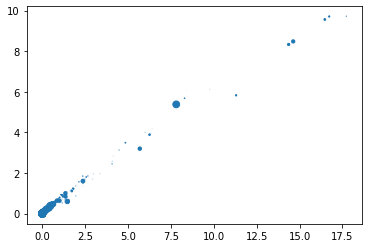

In [16]:
with torch.no_grad():
    latent_train = dnb_ffnn.encoder(dnb_ffnn.get_images(drum_train), dnb_ffnn.get_conditionings(drum_train))
    
mu, dev = latent_train
mu
# libraries
import matplotlib.pyplot as plt
import numpy as np
 
# create data
x = mu[:,0]*100
y = mu[:,1]*100
z = dev
 
# use the scatter function
plt.scatter(x, y, s=z*100)
plt.show()


Попробуем сохранить результаты работы сети. На anaconda нет mido, поэтому сохраняем результаты работы просто в массивчик npy... Однако, как альтернатива, его можно поставить чере pip в conda:
https://github.com/mido/mido/issues/198

In [65]:
import mido
from decode_patterns.data_conversion import build_track, DrumMelodyPair, NumpyImage, Converter


converter = Converter((data_height, data_width))

def output_midi(batch_drum, batch_bass, folder):
    with torch.no_grad():
        bass_outputs = dnb_ffnn(batch_drum)[0]
        bass_outputs = ((bass_outputs.squeeze() + 1) / 2 > 0.55).int()

        for i in range(len(batch_drum)):

            img_dnb = np.concatenate((batch_drum[i].image,bass_outputs[i]), axis=1)
            numpy_pair = NumpyImage(np.array(img_dnb)
                                    , batch_drum[i].tempo
                                    , batch_drum[i].instrument
                                    , 1
                                    , batch_drum[i].min_note)
            pair = converter.convert_numpy_image_to_pair(numpy_pair)
            mid = build_track(pair, tempo=pair.tempo)
            mid.save(f"{folder}/sample{i+1}.mid")

Выводим обучающую и валидационную выборку

In [66]:
# если очень надо послушать тренировчную -- лучше её перезагрузить, потому что она перемешивается
# drum, bass = data_conversion.make_lstm_dataset_conditioning(height=data_height,
#                                                             patterns_file=train_file,
#                                                             mono=False)
# output_midi(drum, bass, "midi/vae_fcnn_fcnn/train")
output_midi(drum_validation, bass_validation, "midi/vae_fcnn_fcnn/validation")

По вкусу, выводим тот же результат для кожанных мешков на ассесмент. На самом деле ничем от валидационной выборки не отличается :)

In [67]:
drum_hum, bass_hum = data_conversion.make_lstm_dataset_conditioning(height=data_height, patterns_file=human_file, mono=False)
output_midi(drum_hum, bass_hum, "midi/vae_fcnn_fcnn/human")

Попробуем сделать градиент от двух базовых партий!

In [28]:
# sample1_id = 89
# sample2_id = 49

steps = 10 # количество шагов между семплами
sample1_id = 17
sample2_id = 73
sample1 = drum_hum[sample1_id]
sample2 = drum_hum[sample2_id]

# вычисляем два вектора в латентном пространстве
with torch.no_grad():
    sampls = [sample1, sample2]
    latent_train = dnb_ffnn.encoder(dnb_ffnn.get_images(sampls), dnb_ffnn.get_conditionings(sampls))
    mu, dev = latent_train

    sample1_latent = mu[0]
    sample2_latent = mu[1]
    
    # пробегаемся линейно по латентному пространству
    for step in range(steps + 1):
        alpha = step / steps
        latent_sample = sample1_latent + (sample2_latent - sample1_latent)*alpha
        
        # пока что выбираем соответствующую барабанную партию в двоичном виде
        drum_sample = sample1
        if (alpha >= 0.5):
            drum_sample = sample2
            
        # а параметры для кондишнинга -- линейно
        tempo = sample1.tempo + (sample2.tempo - sample1.tempo) * alpha
        # instrument = sample1.instrument + (sample2.instrument - sample1.instrument) * alpha
        instrument = drum_sample.instrument
        
        # декодируем линейную комбинацию
        conditionings = torch.tensor([tempo, instrument]).float()
        upsample = dnb_ffnn.decoder(latent_sample.unsqueeze(dim=0), conditionings.unsqueeze(dim=0))
        upsample =  upsample.view((data_height, melody_width))
        upsample = ((upsample.squeeze() + 1) / 2 > 0.55)
        
        
        # сохраняем в файл
        img_dnb = np.concatenate((drum_sample.image,upsample), axis=1)
        numpy_pair = NumpyImage(np.array(img_dnb)
                                , tempo
                                , int(instrument)
                                , 1
                                , drum_sample.min_note)
        pair = converter.convert_numpy_image_to_pair(numpy_pair)
        mid = build_track(pair, tempo=pair.tempo)
        mid.save(f"midi/vae_fcnn_fcnn/grad/gradient{step}.mid")
        
